# Determine parameters of Celcius-Fahrenheit converting formula

## Answer

\begin{align}
F = \frac{9}{5} C + 32
\end{align}

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt

## Generating data with randomness

In [2]:
xs = np.arange(-5, 15, 0.05)
ys = np.array([x*9/5+32 + random.gauss(0,3) for x in xs])

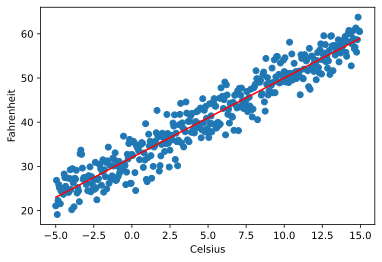

In [3]:
ys_ideal = np.array([x*9/5+32 for x in xs])
plt.scatter(xs,ys)
plt.plot(xs,ys_ideal, color='red')
plt.xlabel('Celsius')
plt.ylabel('Fahrenheit')
plt.show()

Consider $\mathop{\rm arg~max}\limits_{\alpha,\beta} \sum_{j=1}^N (\hat{y}_j - y_j)^2$, where $\hat{y}_j = \alpha x_j + \beta$.
\begin{align}
\frac{\partial}{\partial \alpha} \sum_{j=1}^N (\hat{y}_j - y_j)^2 &= \sum_{j=1}^N 2x_j(\alpha x_j + \beta - y_j) = 2\Big( \left(\sum x_j^2\right) \alpha + \left(\sum x_j\right) \beta - \sum x_j y_j \Big), \\
\frac{\partial}{\partial \beta} \sum_{j=1}^N (\hat{y}_j - y_j)^2 &= \sum_{j=1}^N 2(\alpha x_j + \beta - y_j) = 2\Big( \left(\sum x_j\right) \alpha + N \beta - \sum y_j \Big).
\end{align}

Solving the normal equation, we get $\alpha = \frac{\sum (x_j -\bar{x})(y_j - \bar{y})}{\sum(x_j - \bar{x})^2},\ \beta = \bar{y} - \alpha \bar{x}$, where $\bar{x} = \frac{1}{N}\sum x_j,\ \bar{y} = \frac{1}{N}\sum y_j$

## Verification 1 - Direct Calculation

In [4]:
xs_mean = np.mean(xs)
ys_mean = np.mean(ys)
alpha = np.sum((xs - xs_mean)*(ys - ys_mean))/np.sum((xs - xs_mean)**2)
beta = ys_mean - alpha * xs_mean

print('estimate:', alpha, beta)
print('ideal:', 9/5, 32)

estimate: 1.8103115195284565 32.08597124079442
ideal: 1.8 32


## Verification 2 - using scikit-learn

In [5]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression()
model_lr.fit(xs.reshape(-1,1), ys.reshape(-1,1))
coef, intercept = model_lr.coef_[0][0], model_lr.intercept_[0]

print('estimate:', coef, intercept)
print('ideal:', 9/5, 32)

estimate: 1.8103115195284571 32.08597124079442
ideal: 1.8 32


## Verification 3 - using JAX

In [6]:
from jax import grad
import jax.numpy as jnp

Let $\sigma_x$, $\sigma_y$ be the standard deviations of $\{x_j\}$ and $\{y_j\}$.

If the optimized values $\tilde{\alpha}$ and $\tilde{\beta}$ are satisfied for $\frac{y_j - \bar{y}}{\sigma_y} = \tilde{\alpha} \frac{x_j - \bar{x}}{\sigma_x} + \tilde{\beta}$, then $y_j = (\tilde{\alpha} \frac{\sigma_y}{\sigma_x}) x + (\bar{y} + \tilde{\beta} \sigma_y - \bar{x} \frac{\sigma_y}{\sigma_x})$. So $\alpha = \tilde{\alpha} \frac{\sigma_y}{\sigma_x}$ and $\beta = \bar{y} + \tilde{\beta} \sigma_y - \bar{x} \frac{\sigma_y}{\sigma_x}$.

In [7]:
xs_std = np.std(xs)
ys_std = np.std(ys)

xs_n = (xs - xs_mean) / xs_std
ys_n = (ys - ys_mean) / ys_std

In [8]:
def model(params, x):
    W, b = params
    return x * W + b

def loss(params, x, y):
    preds = model(params, x)
    return jnp.mean((preds - y)**2)

def update(params, x, y, lr=0.1):
    return params - lr * grad(loss)(params, x, y)

In [9]:
params = jnp.array([0., 0.])

for _ in range(5000):
    params = update(params, xs_n, ys_n)

a, b = params
a = a * ys_std / xs_std
b = ys_mean + b * ys_std - xs_mean * ys_std / xs_std

print('estimate:', a, b)
print('ideal:', 9/5, 32)

estimate: 1.8103114 31.748932
ideal: 1.8 32


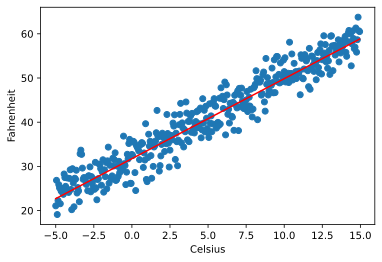

In [10]:
plt.scatter(xs,ys)
params = jnp.array([a, b])
plt.plot(xs,model(params,xs), color='red')
plt.xlabel('Celsius')
plt.ylabel('Fahrenheit')
plt.show()